<a href="https://colab.research.google.com/github/febri009/BERAS.AI/blob/master/rice_quality_mobile_net_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import absolute_import, print_function, division, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Import the Dataset from Google Drive



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Inspect the Dataset

The contents of the drive are imported to the base directory /content/drive/MyDrive/Rice_Quality_Classification, which contains train and validation subdirectories for the training and validation datasets.

The training set is the data that is used to tell the neural network model that 'this is what a premium quality of rice looks like', 'this is what a medium quality of rice looks like', or 'this is what a not feasible quality of rice looks like'. The validation set is images of premium, medium, or not feasible rice quality that the neural network will not see as part of the training. We can use this to test how well or how badly it does in evaluating if an image contains a premium, medium or a not feasible.

These subdirectories in turn each contain premium, medium, and not feasible subdirectories.

In [ ]:
import os

base_dir = '/content/drive/MyDrive/Rice_Quality_Classification'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(os.path.join(base_dir, 'train')))

print("\nContents of validation directory:")
print(os.listdir(os.path.join(base_dir, 'validation')))

Contents of base directory:
['train', 'validation']

Contents of train directory:
['premium', 'medium', 'tidak_layak']

Contents of validation directory:
['premium', 'tidak_layak', 'medium']


We will assign each of these directories to a variable so we can use it later.

In [ ]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training rice quality pictures
train_premium_dir = os.path.join(train_dir, 'premium')
train_medium_dir = os.path.join(train_dir, 'medium')
train_tidak_layak_dir = os.path.join(train_dir, 'tidak_layak')

# Directory with validation rice quality pictures
validation_premium_dir = os.path.join(validation_dir, 'premium')
validation_medium_dir = os.path.join(validation_dir, 'medium')
validation_tidak_layak_dir = os.path.join(validation_dir, 'tidak_layak')

Now, see what the filenames look like in the rice quality train and validation directories (file naming conventions are the same in the validation directory).

In [ ]:
# Display the filenames of rice quality directories
train_premium_fnames = os.listdir(train_premium_dir)
train_medium_fnames = os.listdir(train_medium_dir)
train_tidak_layak_fnames = os.listdir(train_tidak_layak_dir)

print(train_premium_fnames[:10])
print(train_medium_fnames[:10])
print(train_tidak_layak_fnames[:10])

['rojo_lele_premium_flash (61).jpg', 'rojo_lele_premium_flash (68).jpg', 'pandan_wangi_premium_flash (18).jpg', 'ir64_premium_flash (11).jpg', 'rojo_lele_premium_flash (36).jpg', 'ir64_premium_flash (23).jpg', 'pandan_wangi_premium_flash (8).jpg', 'pandan_wangi_premium_flash (34).jpg', 'rojo_lele_premium_flash (26).jpg', 'pandan_wangi_premium_flash (62).jpg']
['rojo_lele_medium_flash (45).jpg', 'pandan_wangi_medium_flash (9).jpg', 'pandan_wangi_medium_flash (38).jpg', 'pandan_wangi_medium_flash (60).jpg', 'pandan_wangi_medium_flash (66).jpg', 'rojo_lele_medium_flash (21).jpg', 'pandan_wangi_medium_flash (51).jpg', 'ir64_medium_flash (1).jpg', 'rojo_lele_medium_flash (50).jpg', 'ir64_medium_flash (58).jpg']
['ir64_tidak_layak_flash (17).jpg', 'rojo_lele_tidak_layak_flash (66).jpg', 'ir64_tidak_layak_flash (65).jpg', 'pandan_wangi_tidak_layak_flash (66).jpg', 'ir64_tidak_layak_flash (21).jpg', 'pandan_wangi_tidak_layak_flash (47).jpg', 'rojo_lele_tidak_layak_flash (40).jpg', 'ir64_tidak_

Let's find out the total number of premium, medium, and tidak layak images in the train and validation directories!

In [ ]:
print('There are' , len(os.listdir(train_premium_dir)), 'images of premium for training')
print('There are' , len(os.listdir(train_medium_dir)), 'images of medium for training')
print('There are' , len(os.listdir(train_tidak_layak_dir)),  'images of tidak layak for training')
print('\nThere are' , len(os.listdir(validation_premium_dir)), 'images of premium for validation')
print('There are' , len(os.listdir(validation_medium_dir)), 'images of medium for validation')
print('There are' , len(os.listdir(validation_tidak_layak_dir)), 'images of tidak layak for validation')

There are 480 images of premium for training
There are 480 images of medium for training
There are 480 images of tidak layak for training

There are 120 images of premium for validation
There are 120 images of medium for validation
There are 120 images of tidak layak for validation


For premium, medium, and not feasible we have 480 training images and 120 validation images respectively.

Now, take a look at a few pictures to get a better sense of what the premium, medium, and not feasible datasets of rice quality look like. First, configure the matplotlib parameters.

In [ ]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x6 configuration
nrows = 6
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 premium, 8 medium, and 8 not feasible pictures. We will re-run the cell to see a fresh batch each time.

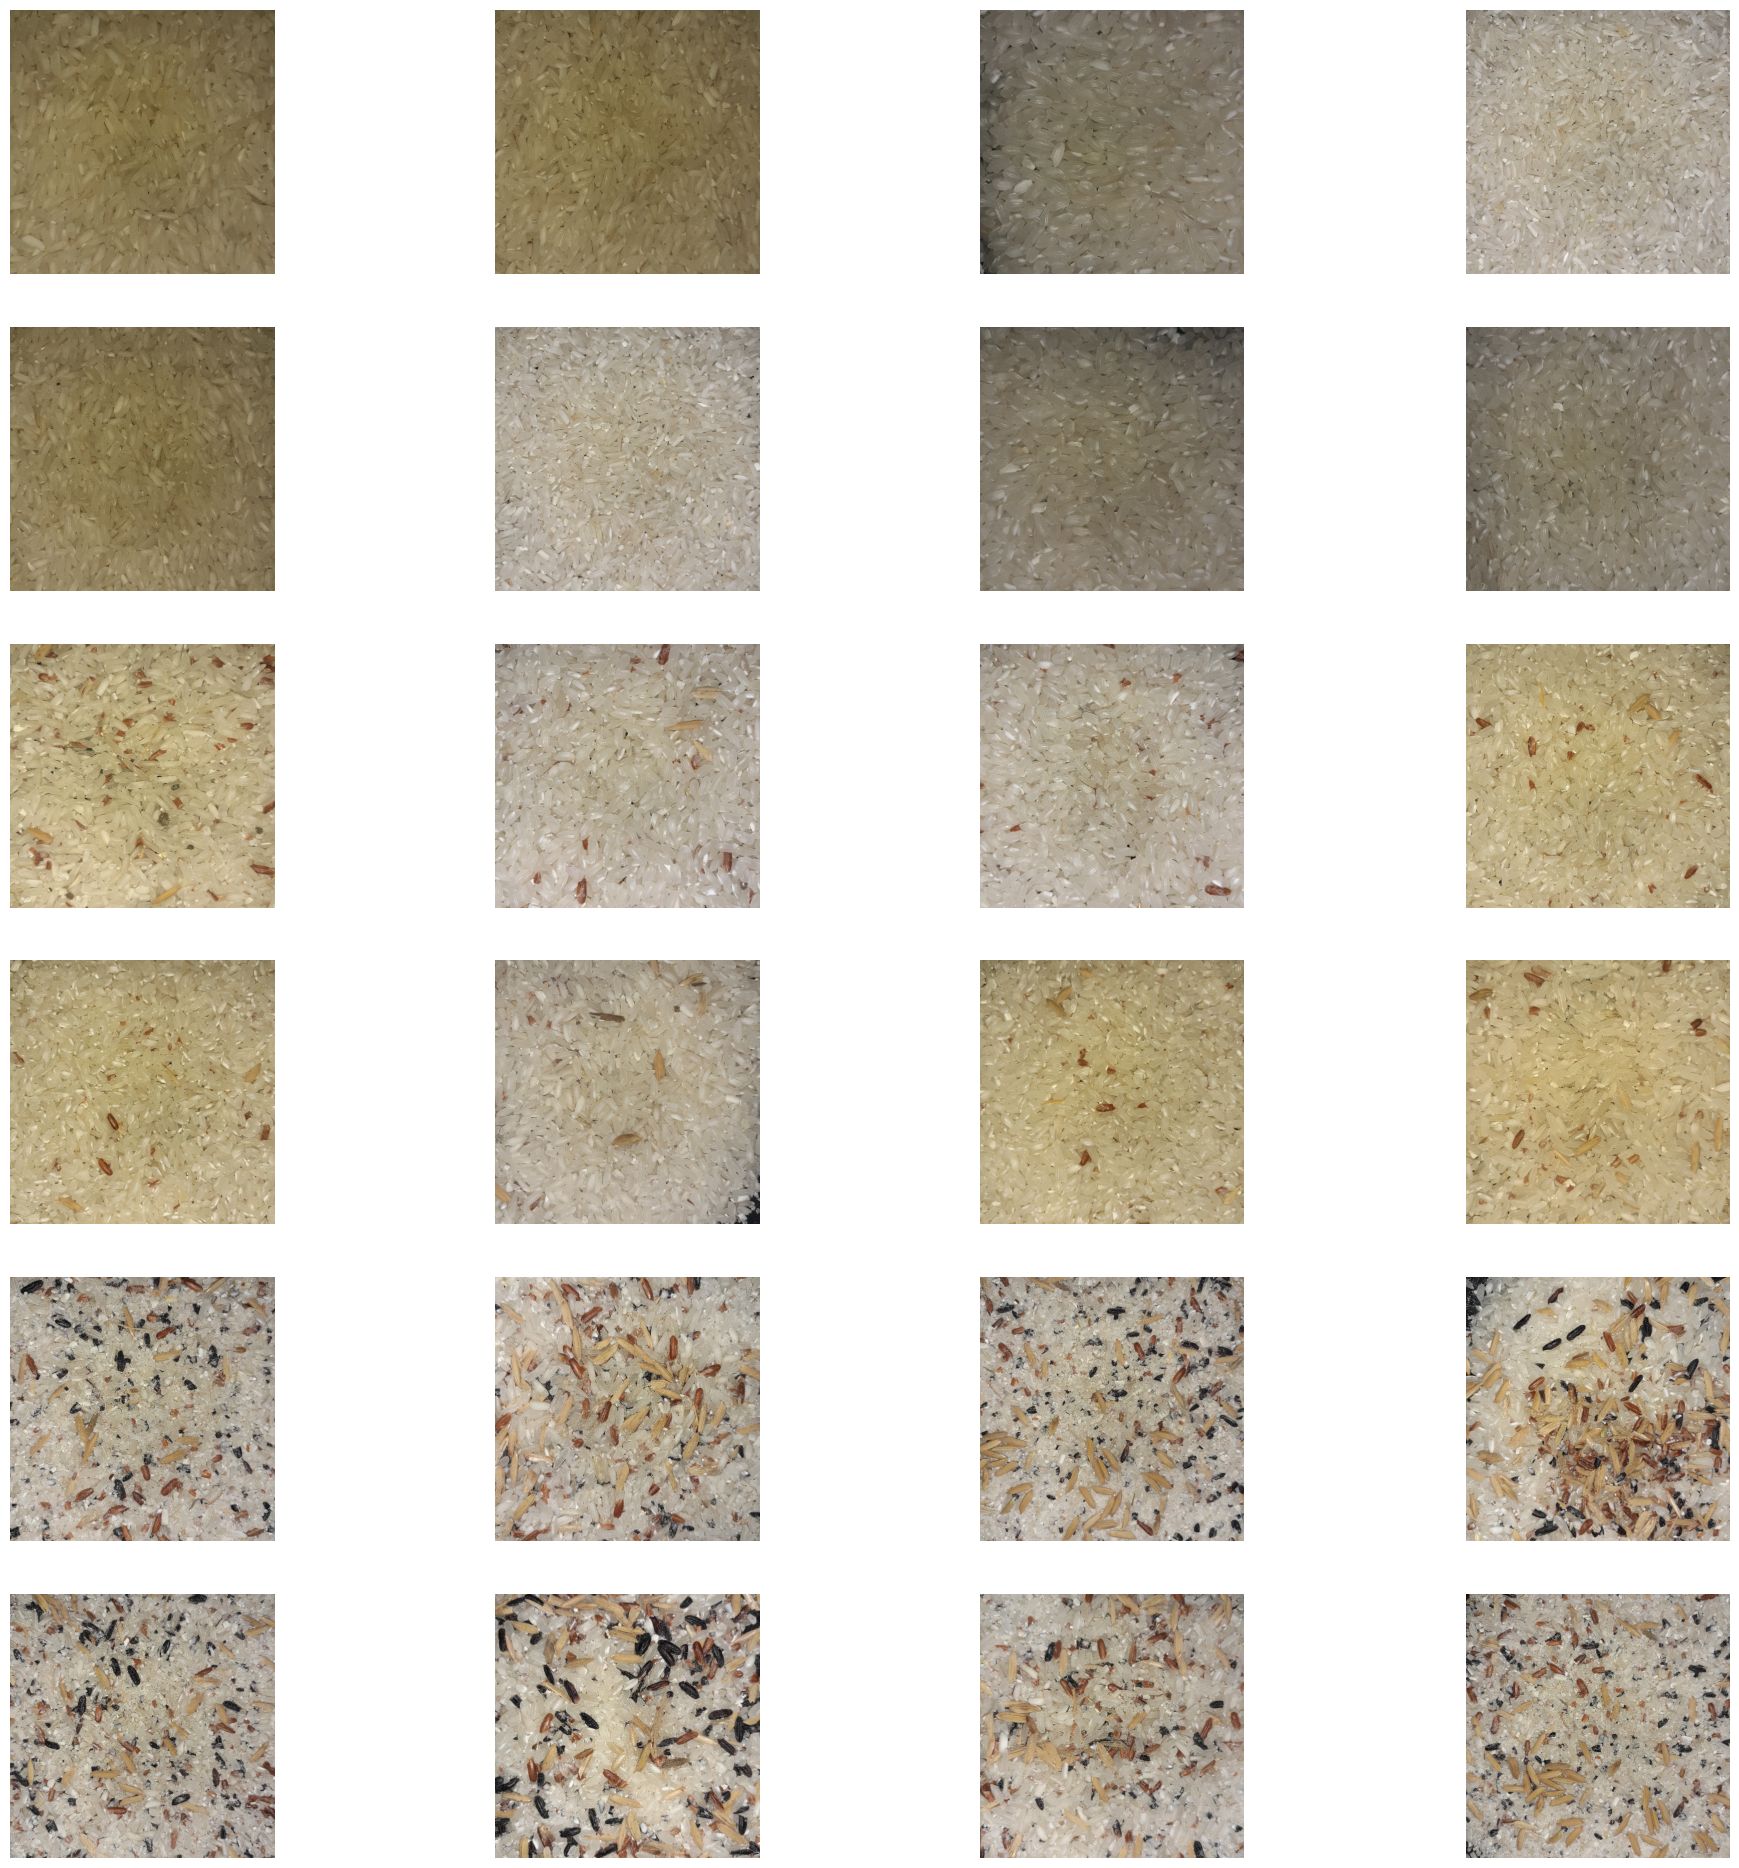

In [ ]:
# Set up matplotlib fig, and size it to fit 4x6 pics
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)

pic_index+=8

next_premium_pix = [os.path.join(train_premium_dir, fname)
                for fname in train_premium_fnames[ pic_index-8:pic_index]
               ]

next_medium_pix = [os.path.join(train_medium_dir, fname)
                for fname in train_medium_fnames[ pic_index-8:pic_index]
               ]
next_tidak_layak_pix = [os.path.join(train_tidak_layak_dir, fname)
                for fname in train_tidak_layak_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_premium_pix+next_medium_pix+next_tidak_layak_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

# Load the first example of a happy face
sample_image  = mpimg.imread(img_path)

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")
print(f"The maximum pixel value used is: {np.max(sample_array)}")

Each image has shape: (600, 600, 3)
The maximum pixel value used is: 255.0


## Prepare the ImageDataGenerator

We will prepare the generators and set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'train')
training_datagen = ImageDataGenerator(rescale=1./255.0,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

validation_dir = os.path.join(base_dir, 'validation')
validation_datagen = ImageDataGenerator(rescale=1./255.0)

train_generator = training_datagen.flow_from_directory(train_dir,
                                                       batch_size=32,
                                                       class_mode='categorical',
                                                       target_size=(224,224))

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(224,224))

Found 1440 images belonging to 3 classes.
Found 360 images belonging to 3 classes.


In [ ]:
base_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),
                                             include_top=False,
                                             weights='imagenet')

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

## Building the Model

To train a neural network to handle the images, we'll need them to be in a uniform size. We will choose 150x150 pixels for this, and we'll see the code that preprocesses the images to that shape shortly.

We can define the model by importing Tensorflow and using the Keras API.

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


We can examine the architecture with model.summary() below.

We'll then compile the model. The key change here is the loss function. We use the categorical_crossentropy because we have three labels for classification.

## Train the Model and Evaluate the Results

We will train for 15 epochs and evaludate the results afterwards. We observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to only our training set.

In [ ]:
history = model.fit_generator(train_generator,
                    epochs=25,
                    validation_data=validation_generator)

<ipython-input-23-9f3180eb286a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/25
45/45 [==============================] - 331s 7s/step - loss: 0.2800 - acc: 0.9222 - val_loss: 0.0643 - val_acc: 0.9806
Epoch 2/25
45/45 [==============================] - 78s 2s/step - loss: 0.0211 - acc: 0.9951 - val_loss: 0.0399 - val_acc: 0.9806
Epoch 3/25
45/45 [==============================] - 81s 2s/step - loss: 0.0151 - acc: 0.9958 - val_loss: 0.0508 - val_acc: 0.9778
Epoch 4/25
45/45 [==============================] - 82s 2s/step - loss: 0.0179 - acc: 0.9937 - val_loss: 0.1017 - val_acc: 0.9722
Epoch 5/25
45/45 [==============================] - 73s 2s/step - loss: 0.0068 - acc: 0.9993 - val_loss: 0.0439 - val_acc: 0.9833
Epoch 6/25
45/45 [==============================] - 78s 2s/step - loss: 0.0078 - acc: 0.9972 - val_loss: 0.0284 - val_acc: 0.9889
Epoch 7/25
45/45 [==============================] - 79s 2s/step - loss: 0.0057 - acc: 0.9986 - val_loss: 0.0226 - val_acc: 0.9889
Epoch 8/25
45/45 [==============================] - 71s 2s/step - loss: 0.0076 - acc: 0.9

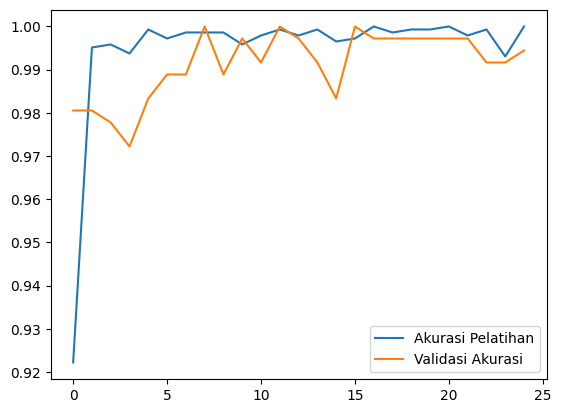

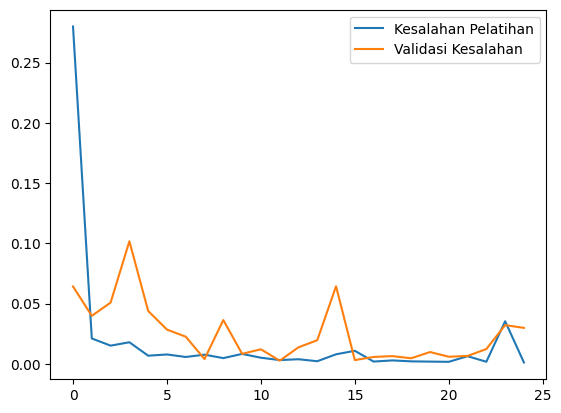

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

## Model Prediction

Now take a look at actually running a prediction using the model. This code will allow we to choose 1 or more files from our file system, upload them, and run them through the model, giving an indication of whether the rice quality is a premium, medium, or not feasible..

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = load_img(path, target_size=(224,224))

  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)

  print(classes[0])

  if classes[0][1] > 0.5:
        print(fn + " Premium")
  elif classes[0][2] > 0.5:
        print(fn + " Tidak Layak")
  else:
        print(fn + " Medium")

Saving sample4.PNG to sample4.PNG
1/1 [==============================] - 0s 44ms/step
[8.4767744e-06 2.5625873e-09 9.9999154e-01]
sample4.PNG Tidak Layak


In [ ]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Kualitas_Beras_MobileNet.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
model.save(f'Klasifikasi_Kualitas_Beras_MobileNet.h5')